# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [1]:
!pip3 install scikit-learn pandas matplotlib transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.5 MB/s eta 0:00:00


In [2]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)
data.shape

(607, 6)

### Модель1: bert-base-multilingual-cased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-cased', trainable=True)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4,
         epochs=20)

Epoch 1/20


144/144 [==============================] - 121s 570ms/step - loss: 2.8571 - accuracy: 0.0625 - rec_prec: 0.0000e+00 - val_loss: 2.7044 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
144/144 [==============================] - 76s 528ms/step - loss: 2.7809 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.6974 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 3/20
144/144 [==============================] - 75s 524ms/step - loss: 2.7860 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.6940 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
144/144 [==============================] - 76s 529ms/step - loss: 2.7519 - accuracy: 0.0885 - rec_prec: 0.0000e+00 - val_loss: 2.6788 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
144/144 [==============================] - 76s 528ms/step - loss: 2.7482 - accuracy: 0.0955 - rec_prec: 0.0000e+00 - val_loss: 2.6685 - val_accuracy: 0.1613 - val_rec_prec: 0.0000e+00
Epoch 6/20
144/144 [===============

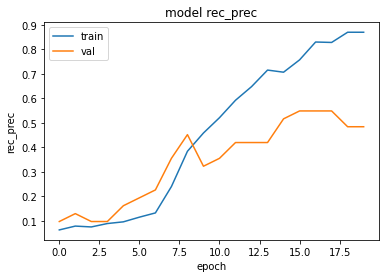

In [ ]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 [==============================] - 4s 190ms/step
                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
        Экономика       0.33      0.50      0.40         2
          Легпром       1.00      1.00      1.00         1
           Россия       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
      Бывший СССР       0.33      0.33      0.33         3
Силовые структуры       0.67      1.00      0.80         2
            Спорт       0.67      1.00      0.80         2
  Наука и техника       1.00      0.33      0.50         3
              Дом       0.33      0.50      0.40         2
         Ценности       0.50      0.50      0.50         2
         Из жизни       1.00      0.33      0.50         3
   69-я параллель       0.50      1.00      0.67         1
           Бизнес       0.50      0.50      0.50         2
  

### Модель 2: smaller-LaBSE

In [6]:
tokenizer2 = AutoTokenizer.from_pretrained('setu4993/smaller-LaBSE')
model_labse = TFAutoModel.from_pretrained('setu4993/smaller-LaBSE', trainable=True)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at setu4993/smaller-LaBSE.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
X = []

for text in data.title:
    ids = tokenizer2.encode(text)
    
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [8]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_labse({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [9]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4,
         epochs=20)

Epoch 1/20


144/144 [==============================] - 115s 514ms/step - loss: 2.8111 - accuracy: 0.0972 - rec_prec: 0.0000e+00 - val_loss: 2.6922 - val_accuracy: 0.0968 - val_rec_prec: 0.0323
Epoch 2/20
144/144 [==============================] - 71s 493ms/step - loss: 2.6783 - accuracy: 0.1389 - rec_prec: 0.0000e+00 - val_loss: 2.5654 - val_accuracy: 0.1935 - val_rec_prec: 0.0323
Epoch 3/20
144/144 [==============================] - 73s 510ms/step - loss: 2.3908 - accuracy: 0.2569 - rec_prec: 0.0312 - val_loss: 2.3558 - val_accuracy: 0.2258 - val_rec_prec: 0.0323
Epoch 4/20
144/144 [==============================] - 73s 507ms/step - loss: 2.0706 - accuracy: 0.3698 - rec_prec: 0.0660 - val_loss: 2.0935 - val_accuracy: 0.3226 - val_rec_prec: 0.0323
Epoch 5/20
144/144 [==============================] - 73s 510ms/step - loss: 1.7435 - accuracy: 0.4688 - rec_prec: 0.1719 - val_loss: 1.8160 - val_accuracy: 0.5484 - val_rec_prec: 0.0323
Epoch 6/20
144/144 [==============================] - 75s 519ms/ste

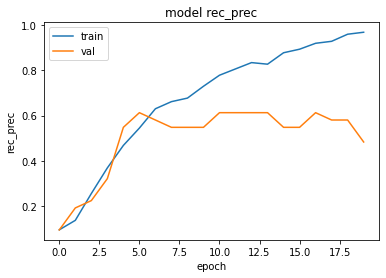

In [10]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 [==============================] - 4s 188ms/step
                   precision    recall  f1-score   support

Силовые структуры       0.33      0.50      0.40         2
        Экономика       0.33      0.50      0.40         2
              Мир       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
   Интернет и СМИ       0.67      1.00      0.80         2
         Ценности       1.00      0.50      0.67         2
              Дом       1.00      0.50      0.67         2
         Из жизни       1.00      0.67      0.80         3
   69-я параллель       0.00      0.00      0.00         1
      Бывший СССР       1.00      0.67      0.80         3
       Библиотека       0.00      0.00      0.00         0
         Культура       0.50      0.33      0.40         3
           Россия       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
  Наука и техника       0.50      0.67      0.57         3
  

### Модель 3: rubert-base-cased-sentiment-rurewiews

In [ ]:
tokenizer3 = AutoTokenizer.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model_rubert = TFAutoModel.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', trainable=True)

In [11]:
X = []

for text in data.title:
    ids = tokenizer3.encode(text)
    
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [12]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_rubert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf_r = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf_r.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [13]:
model_clf_r.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4,
         epochs=20)

Epoch 1/20


144/144 [==============================] - 115s 533ms/step - loss: 2.8716 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.6962 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 2/20
144/144 [==============================] - 74s 514ms/step - loss: 2.7383 - accuracy: 0.1337 - rec_prec: 0.0000e+00 - val_loss: 2.5978 - val_accuracy: 0.1935 - val_rec_prec: 0.0323
Epoch 3/20
144/144 [==============================] - 73s 505ms/step - loss: 2.6324 - accuracy: 0.1562 - rec_prec: 0.0000e+00 - val_loss: 2.4122 - val_accuracy: 0.2903 - val_rec_prec: 0.0323
Epoch 4/20
144/144 [==============================] - 74s 513ms/step - loss: 2.4629 - accuracy: 0.2431 - rec_prec: 0.0000e+00 - val_loss: 2.2115 - val_accuracy: 0.2903 - val_rec_prec: 0.1290
Epoch 5/20
144/144 [==============================] - 74s 515ms/step - loss: 2.1891 - accuracy: 0.3455 - rec_prec: 0.0451 - val_loss: 1.9081 - val_accuracy: 0.3871 - val_rec_prec: 0.2903
Epoch 6/20
144/144 [==============================] - 7

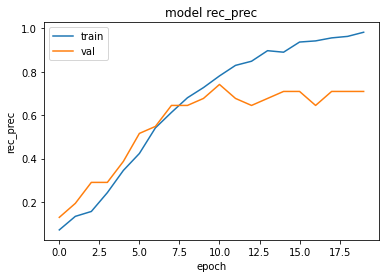

In [14]:
plt.plot(model_clf_r.history.history['accuracy'])
plt.plot(model_clf_r.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
pred = model_clf_r.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 [==============================] - 4s 182ms/step
                   precision    recall  f1-score   support

  Наука и техника       0.75      1.00      0.86         3
      Бывший СССР       0.40      0.67      0.50         3
Силовые структуры       1.00      0.50      0.67         2
   Интернет и СМИ       1.00      1.00      1.00         2
             Крым       0.00      0.00      0.00         0
           Бизнес       1.00      0.50      0.67         2
        Экономика       1.00      1.00      1.00         2
   69-я параллель       0.00      0.00      0.00         1
          Легпром       0.50      1.00      0.67         1
            Спорт       1.00      1.00      1.00         2
         Культура       0.60      1.00      0.75         3
         Из жизни       0.67      0.67      0.67         3
       Библиотека       0.00      0.00      0.00         0
              Мир       1.00      1.00      1.00         1
         Ценности       0.00      0.00      0.00         2
  

### Итоги

**weighted f1**:
- bert-base-multilingual-cased: 0.47 
- smaller-LaBSE: 0.48
- rubert-base-cased-sentiment-rurewiews: 0.65

Я пробовала несколько моделей с русским языком, но у многих f1 на этой задаче не превышают 0.1(. Из лучших моделей, которые приведены в этой тетрадке, лучший результат у rubert-base-cased-sentiment-rurewiews.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT? 

1. **RoBERTa**

RoBERTa и BERT в целом схожи между собой, но есть ряд отличий. В первую очередь, RoBERTa обучалась на значительно больших объемах данных (в 10 раз), и, соответсвенно, имеет больший словарь, но также и большее время обучения. Кроме того, BERT имеет статическую схему маскирования токенов (на всех этапах обучения маскируются одни и те же токены), в то время как RoBERTa - динамическую, то есть меняющуюся на каждом этапе обучения. Это делает RoBERTa более гибкой моделью, так как она обучается учитывать различное распределение токенов в разных контексатх. В-третьих, RoBERTa не обучалась на задании next-sentence-prediction, в отличие от BERT.

Впервые RoBERTa была описана в статье *RoBERTa: A Robustly Optimized BERT Pretraining Approach* (https://arxiv.org/abs/1907.11692)

2. **T5**

T5 отличается от BERT (и подобных ему моделей) в первую очередь более широким спектром задач: если BERT в первую очередь обучался для задач language understanding, таких как классификация текста или вопросно-ответный поиск, то главной задачей T5 является генерация текста. Отсюда разница в том, что модели подают на выход: BERT - эмбеддинги слов, T5 - текстовую строку сгенерированного текста. T5 имеет более сложную архитектуру, BERT состоит только из энкодера, а T5 - и энкодера, и декодера. Наконец, Т5 обучался на больших объемах данных.